In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")


In [ ]:

# Define preprocessing transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

In [ ]:
data_path = '/content/drive/My Drive/dataset2'

data= {x: datasets.ImageFolder(os.path.join(data_path,x), data_transforms[x]) for x in ['train', 'test']}


In [ ]:
# Create data loaders
data_loaders = {x: DataLoader(data[x], batch_size=10, shuffle=True) for x in ['train', 'test']}
data_size= {x: len(data[x]) for x in ['train', 'test']}
names= data['train'].classes
names


# Define the model
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # Output layer with number of classes in the dataset

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 65.8MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
names= data['train'].classes
names
print(data_size)



train_loader = data_loaders['train']
test_loader = data_loaders['test']




{'train': 8000, 'test': 2520}


In [ ]:

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_predictions
    return running_loss / len(train_loader.dataset), accuracy

# Validation function
def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    accuracy = accuracy_score(all_labels, all_predictions)
    confusion = confusion_matrix(all_labels, all_predictions)
    return running_loss / len(test_loader.dataset), accuracy, confusion

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

num_epochs = 40

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, data_loaders['train'], criterion, optimizer, device)
    test_loss, test_accuracy, test_confusion = test(model, data_loaders['test'], criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print("Test Confusion Matrix:")
    print(test_confusion)

In [ ]:
#torch.save(model.state_dict(), 'asma_earlystop.pth')

In [ ]:
# Plotting the results
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
def evaluate_overall_accuracy(model, loader, device):
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_predictions

    return  accuracy

# Calculate overall accuracy on the combined dataset (train + test)
overall_train_accuracy = evaluate_overall_accuracy(model, train_loader, device)
overall_test_accuracy = evaluate_overall_accuracy(model, test_loader, device)

print(f"Overall Training Accuracy: {overall_train_accuracy:.4f}")
print(f"Overall Test Accuracy: {overall_test_accuracy:.4f}")

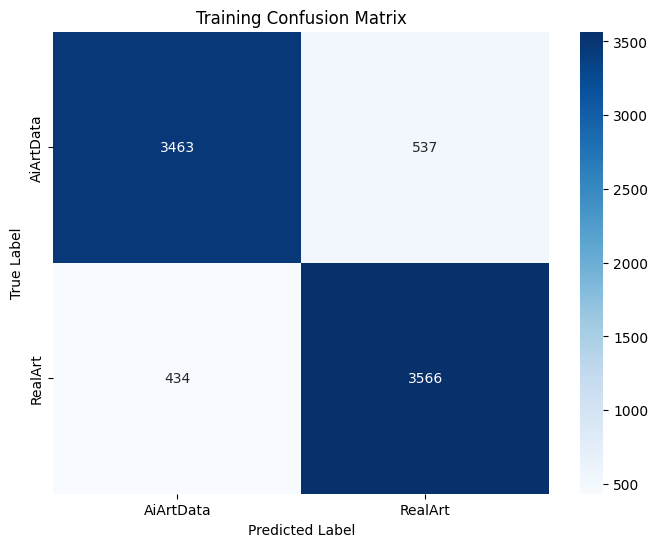

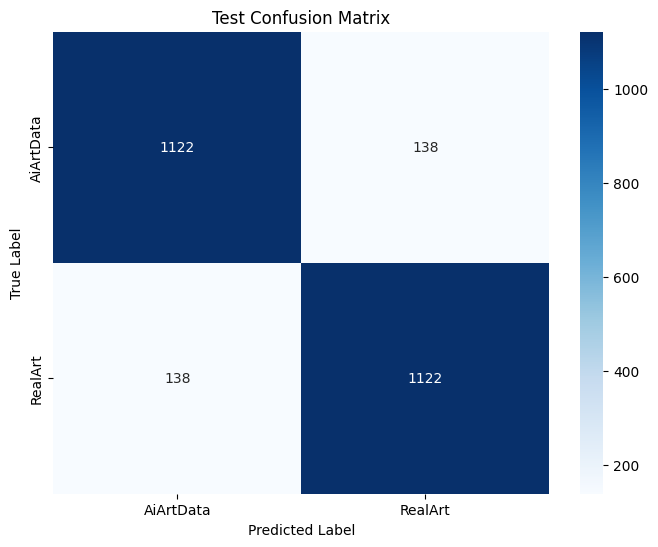

In [ ]:
def plot_confusion_matrix(confusion_matrix, class_names, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Calculate confusion matrix for the training set
train_confusion_matrix = evaluate_confusion_matrix(model, train_loader, device)

# Calculate confusion matrix for the test set
test_confusion_matrix = evaluate_confusion_matrix(model, test_loader, device)

# Get the class names (assuming 'names' is a list of class names)
class_names = data['train'].classes

# Plot the training confusion matrix
plot_confusion_matrix(train_confusion_matrix, class_names, title="Training Confusion Matrix")

# Plot the test confusion matrix
plot_confusion_matrix(test_confusion_matrix, class_names, title="Test Confusion Matrix")